# Applying Coordinate Transformations to Facilitate Data Comparison

## Performing ITRF and Plate Movement Models to Lidar data from Pre-IceBridge, ICESat-1, IceBridge, and ICESat-2 datasets

Given Lidar data (latitude, longitude, elevation, etc) taken from a Pre-IceBridge mission in 1993 and data collected from ICESat-2 in 2018, how may we meaningfully compare these two datasets collected 25-years apart? There are number of factors to consider in such a comparison, and these include changes in coordinate reference frames and tectonic plate movement across the time series. Given the accuracy and precision of the data, combined with the long time series now available, we investigate their effects. As an example of the rough magnitude of these effects, the Australian plate is moving at a rate of around 7 cm / year, and recently collected satellite and airborne imagery illustrate how this has resulted in a noticeable visible shift from imagery taken in the mid 1990s--over this time the continent has moved nearly 1.8 m. All other areas of the world exhibit similar, if smaller, effects. In this notebook we will enumerate the factors that may bear upon these types of data comparisons, quantify the magnitude of their effects, and illustrate two methods to transform the datasets into a form in which these effects may be mitigated.

## The Factors

1. The coordinate reference systems (CRS) relative to which the coordinates (latitude, longitude, elevation) in the datasets are given
2. The epoch in which the coordinate reference systems are based
3. The epoch in which the coordinates in the datasets were measured
4. Tectonic Plate movements over time that can result in a marked ("fixed") location on the Earth having different coordinates, depending on the type of CRS in which those coordinates are measured.

## Coordinate Reference Systems (CRS)

At the risk of oversimplifying a complicated subject, we try to provide a baseline set of terms and concepts that will be important for the rest of the notebook.

* Coordinate system: A coordinate system will have a dimension; latitude/longitude coordinates are a two-dimensional system, for example. It will also have a convention for the order in which the coordinates are listed, the names of each dimension, and the unit of measurement (a scale) for each dimension. A coordinate system by itself is abstract. We need to "anchor" the coordinate system to a body we wish to measure.

* Datum: This defines both the origin point and the direction vectors of the axes of a coordinate system with respect to a particular body, in our case the Earth.

* A Coordinate Reference System consists of the choice of coordinate system and a datum which "attaches" and orients the coordinate system.

For the purpose of this notebook, we will consider two types of coordinate reference systems (CRS):

* Dynamic - The CRS is global and Earth-centered and Earth-fixed. Consequently coordinates of a geographic feature may change over time as tectonic plates move.
* Static - The CRS is regional and fixed to a tectonic plate. Coordinates of a geographic feature are stable / fixed as the plate itself moves.

The nomenclature may be confusing and other terms are used in various sources. To clarify the terms we're using in this notebook: in a dynamic CRS, the CRS itself is relatively fixed, but the coordinates are dynamic over time. Likewise, in a static CRS, the CRS itself is actually floating along with the underlying plate, and it is the coordinates that are static over time.

The International Terrestrial Reference Frame (ITRF) realizations are examples of dynamic frames. The International Earth Rotation Service (IERS) maintains the International Terrestrial Reference System (ITRS). The ITRS is a formal description of the coordinate reference system, along with the mathematical and experimental procedures used to create the actual concrete reference frame. The concrete reference frame is called a realization. These realizations are issued every few years, and are created as both the Earth changes and as the procedures and data get better and more precise. Examples include ITRF88, ITRF93, ITRF2000, etc. We can think of a specific ITRF as being anchored at the Earth's center of mass (to within a centimeter!), the z-axis as oriented along the Earth's pole (a simplification), the x-axis as roughly pointing to the Greenwich meridian, and the y-axis orthogonal to the other two, forming a right-handed coordinate system. The IERS gathers data on pole precession and nutation, various geophysical effects on the Earth due to ocean and astronomical tides, and the length of day. Periodically the IERS will issue a new ITRF, as well as parameters for transforming to and from older ITRF realizations. This makes it convenient to compare locations at any point on the Earth, but only for the same time, or epoch. Comparing coordinates in a dynamic frame from different epochs presents problems since the geographic features are being moved by plate tectonics, resulting in different coordinates for the same feature.

In contrast with global dynamic frames like the ITRFs, we can have regional CRSs for an entire continent (e.g. Australia), or even specific countries. These offer convenience for locating features in that region; the coordinates for any object in Ireland, for example, may be easily compared across time, but those coordinates are not immediately comparable the coordinates for the feature in a different reference frame, static or dynamic.

Finally, the term epoch is used to identify the reference date at which a given reference frame was realized, and also when the coordinates for a particular observation (e.g., lat, lon, elevation) were obtained. For example, GPS coordinates are currently relative to reference frame ITRF 2014 which has a realization epoch of 2010.0. GPS coordinates obtained right now would have an epoch of 2019.x. These epochs will become important as we apply transforms below.

## Example Dataset

For the remainder of the notebook, we will use a fictitious dataset comprised of latitude, longitude, and elevation coordinates. We will illustrate the use of PROJ and PyProj to perform transformations between CRSs, and coordinate propagation between epochs in the same CRS using a Plate Motion Model. We construct a set of coordinates roughly on the Greenland ice sheet, with fictitious elevations. The particular values are used for illustration of the effects of coordinate transformation and propagation (defined later).

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from pyproj import Geod, Transformer

In [3]:
# We're going to illustrate an example of fictitious data from 1993 being transformed to be comparable to data from 2018.
epoch1 = 1993.5
itrf1 = "ITRF93"
epoch2 = 2018.5
itrf2 = "ITRF2014"

# Create lats and lons evenly spaced 1x1m grid (1 cm spacing) anchored to a point on the Greenland icesheet.
lat0 = 70.0
lon0 = -50.0
lat_deg_m = (1 / 111000.0)  # (~degrees / m)
lon_deg_m = (1 / 34300.0)  # (~degrees / m)
delta_lat = lat_deg_m * 0.01  # 1 cm
delta_lon = lon_deg_m * 0.01  # 1 cm
num_points = 11
lats = lat0 + np.arange(num_points) * delta_lat
lons = lon0 + np.arange(num_points) * delta_lon
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Create elevations for illustration of coordinate transformation and propagation effects. The resulting "surface" will just be plane at constant elevation.
elev_grid = np.ones(lon_grid.shape)

# We set the observation epoch of the points of our sample dataset.
epoch_grid = epoch1 * np.ones(lon_grid.shape)

Here we show a 10x10 grid spaced at 1cm intervals, and set the elevations of each point at 1m. The absolute latitude longitude values are at 70N, 50W, a spot "on" the Greenland ice sheet. We use this grid of points as our fictitious dataset that we are going to transform using two methods. In the examples that follow, we're going to assume this data was collected in 1993 and we'd like to compare it to data collected in 2018. The fictitious dataset which we will transform will be in the ITRF93 reference frame, and assume the 2018 data we'd like to compare it to is in the ITRF2014 frame.

Note the scale difference on the z-axis. All axes units are meters.

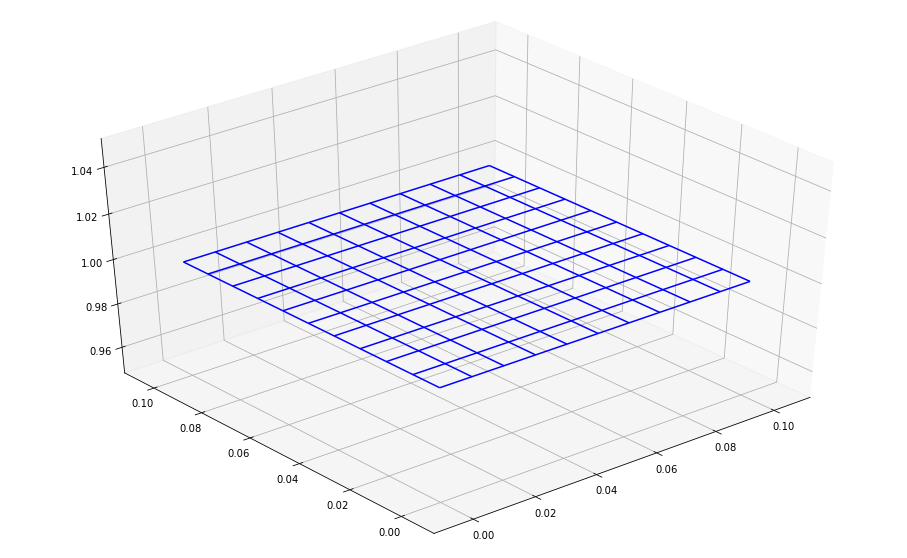

In [3]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 230)
ax.set_xlim(-0.01, 0.11)
ax.set_ylim(-0.01, 0.11)

ax.plot_wireframe((lon_grid - lon0) / lon_deg_m, (lat_grid - lat0) / lat_deg_m, elev_grid, color='blue')

## Coordinate Transformations Between Reference Systems

As stated above, we'd like to transform the data collected in 1993 in the ITRF93 reference frame to allow comparison with points in the ITRF2014 frame. To do so, we create a PROJ pipeline that consists of a series of steps:

* Declare that all the ellipsoids we're dealing with are WGS84
* Convert from degrees to radians
* Convert from lat/lon/elevations to Cartesian coordinates
* Convert from the ITRF93 frame to ITRF2014
* Convert back to latitude / longitude coordinates
* Convert from radians to degrees

In [2]:
def create_transformer(from_crs, to_crs, to_epoch=None):
    plate_model_step = ""
    if to_epoch:
        plate_model_step = f"+step +inv +init={to_crs}:NOAM +t_epoch={to_epoch} "

    pipeline = (
        f"+proj=pipeline +ellps=WGS84 "
        f"+step +proj=unitconvert +xy_in=deg +xy_out=rad "
        f"+step +proj=latlon "
        f"+step +proj=cart "
        f"+step +inv +init={to_crs}:{from_crs} "
        + plate_model_step +                
        f"+step +proj=cart +inv "
        f"+step +proj=unitconvert +xy_in=rad +xy_out=deg"
    )
    return Transformer.from_pipeline(pipeline)

We now calculate the magnitude of the coordinate shifts from ITRF93 to ITRF2014, and then plot the original grid (blue) and the newly shifted grid (green).

In [5]:
t = create_transformer(itrf1, itrf2)

(lons_2014, lats_2014, elevs_2014, epochs_2014) = t.transform(lon_grid.T.flatten(), 
                                                              lat_grid.T.flatten(), 
                                                              elev_grid, 
                                                              epoch1 * np.ones(lon_grid.shape))

max_lon_delta = np.max(abs(lons_2014 - lon_grid.T.flatten()))
print(f"Longitude delta (m): {max_lon_delta / lon_deg_m:0.3f}")
max_lat_delta = np.max(abs(lats_2014 - lat_grid.T.flatten()))
print(f"Latitude delta (m): {max_lat_delta / lat_deg_m:0.3f}")
max_elev_delta = np.max(abs(elevs_2014 - elev_grid))
print(f"Elevation delta (m): {max_elev_delta:0.3f}")

lons_2014 = np.reshape(lons_2014, (num_points, num_points))
lats_2014 = np.reshape(lats_2014, (num_points, num_points))

Longitude delta (m): 0.005
Latitude delta (m): 0.028
Elevation delta (m): 0.005


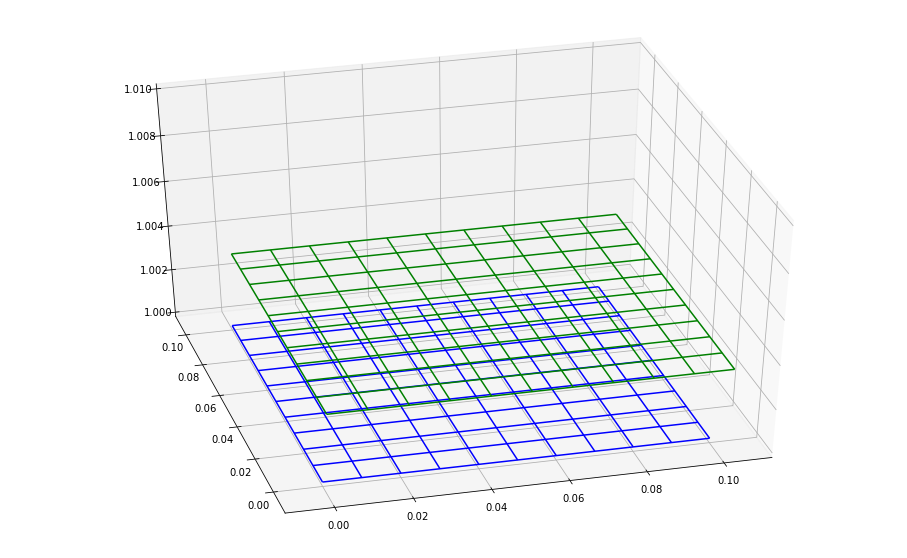

In [6]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 255)
ax.set_xlim(-0.01, 0.11)
ax.set_ylim(-0.01, 0.11)
ax.set_zlim(1, 1.01)

ax.plot_wireframe((lon_grid - lon0) / lon_deg_m, (lat_grid - lat0) / lat_deg_m, elev_grid, color='blue')
ax.plot_wireframe((lons_2014 - lon0) / lon_deg_m, (lats_2014 - lat0) / lat_deg_m, elevs_2014, color='green')

## Coordinate Propagation Between Epochs within One Coordinate Reference System

Now that our example dataset is in the same reference frame as the data with which we'd like to compare it, we'd like to account for the shift in coordinates for a given geographic feature as a result of tectonic plate movement. To do so, we can make use of the ITRF2014 Plate Motion Model (PMM) and apply both the ITRF93 => ITRF2014 coordinate transformation _*and*_ the epoch 1993.5 => 2018.5 shift using the ITRFs PMM model parameters. 

Here we show the original dataset (blue), the dataset with only the ITRF93 => ITRF2014 transformation applied (green), and the dataset obtained by applying the PMM coordinate propagation from 1993.5 through 2018.5 in five-year increments (red). We see that the ITRF93 => ITRF2014 shift applied a relatively small vertical and horizontal shift, and the PMM results in a much larger shift roughly to the northwest. We see that the magnitude of this PMM shift is much more significant, and perhaps significant to the comparison of data between epochs.

In [7]:
def propagated_data(from_crs, to_crs, obs_epoch, to_epoch, lon_grid, lat_grid, elev_grid):
    t = create_transformer(from_crs, to_crs, to_epoch)
    (lons_new, lats_new, elevs_new, epochs_new) = t.transform(lon_grid.T.flatten(), 
                                                              lat_grid.T.flatten(), 
                                                              elev_grid, 
                                                              obs_epoch * np.ones(lon_grid.shape))
    lons_new = np.reshape(lons_new, (num_points, num_points))
    lats_new = np.reshape(lats_new, (num_points, num_points))

    return (lons_new, lats_new, elevs_new, epochs_new)

dict_keys([1993.5, 1998.5, 2003.5, 2008.5, 2013.5, 2018.5])


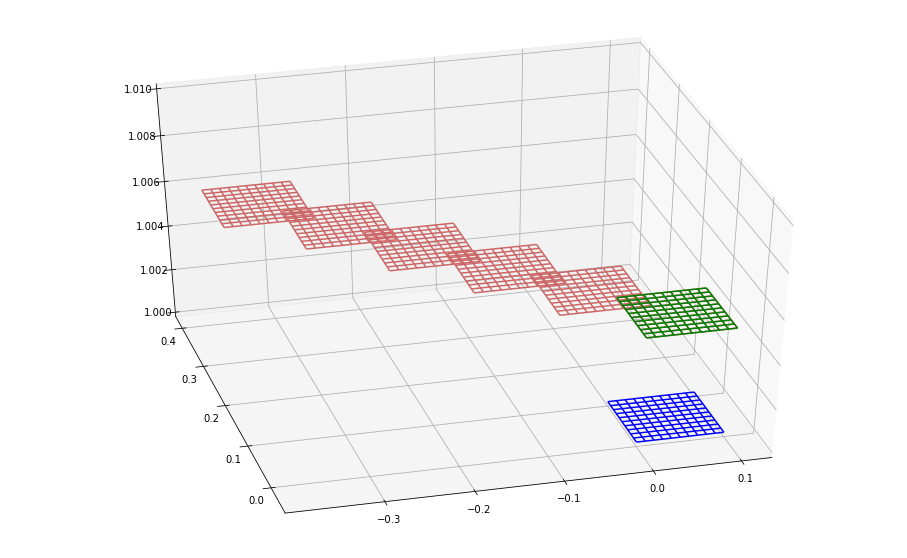

In [8]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 255)
ax.set_zlim(1, 1.01)

ax.plot_wireframe((lon_grid - lon0) / lon_deg_m, (lat_grid - lat0) / lat_deg_m, elev_grid, color='blue')

count = 6
propd_data = {y: propagated_data(itrf1, itrf2, epoch1, y, lon_grid, lat_grid, elev_grid) for y in np.linspace(epoch1, epoch2, count)}
print(propd_data.keys())

for y, (lons, lats, elevs, _) in propd_data.items():
    ax.plot_wireframe((lons - lon0) / lon_deg_m, (lats - lat0) / lat_deg_m, elevs, color=mpl.colors.hsv_to_rgb([1, 0.5, 0.8]))
    
ax.plot_wireframe((lons_2014 - lon0) / lon_deg_m, (lats_2014 - lat0) / lat_deg_m, elevs_2014, color='green')

In [9]:
max_lon_delta = np.max(abs(propd_data[2018.5][0] - propd_data[1993.5][0]))
print(f"Longitude delta (m): {max_lon_delta / lon_deg_m:0.2f}")

max_lat_delta = np.max(abs(propd_data[2018.5][1] - propd_data[1993.5][1]))
print(f"Latitude delta (m): {max_lat_delta / lat_deg_m:0.2f}")

max_elev_delta = np.max(abs(propd_data[2018.5][2] - propd_data[1993.5][2]))
print(f"Elevation delta (m): {max_elev_delta:0.4f}")

Longitude delta (m): 0.37
Latitude delta (m): 0.33
Elevation delta (m): 0.0007


## References

### Overview of the reference frame and plate shift problem
1. [The many paths to a common ground: A comparison of transformations between GDA94 and ITRF](https://www.spatial.nsw.gov.au/__data/assets/pdf_file/0003/165702/2011_Haasdyk_and_Janssen_IGNSS2011_comparison_of_GDA94-ITRF_transformations.pdf)
1. [GDA94, ITRF & WGS84Whatâ€™s the difference?](http://www.quickclose.com.au/stanaway07pres.pdf)
1. [Misaligned maps? High-accuracy data must become time-dependent](https://www.opengeospatial.org/blog/3045)
1. [Dynamic Datum Transformations in Australia and New Zealand](http://ceur-ws.org/Vol-1142/paper6.pdf)
1. [Making Sense of Evolving Datums:WGS84 and NAD83](http://www.naref.org/transf/nad83_hydroscan2006.pdf)
1. [Re: Dynamic/static WGS84 datum problem with web-mapping and map misalignment](http://osgeo-org.1560.x6.nabble.com/Re-Dynamic-static-WGS84-datum-problem-with-web-mapping-and-map-misalignment-td5412013.html)
1. [From static to dynamic datums: 150 years of geodetic datums in New Zealand](https://doi.org/10.1080/00288306.2015.1128451)
1. [The new world of Earth-fixed datums](https://www.spatialsource.com.au/company-industry/new-world-earth-fixed-datums)
1. [FIG/IAG/UN-GGIM-AP/UN-ICG/NZISTechnical Seminar Reference Frame in Practice](https://www.fig.net/resources/proceedings/2016/2016_05_reference%20frame/1_Rizos.pdf)

### ITRF
1. [ITRF](http://itrf.ensg.ign.fr/)
1. [IERS CONVENTIONS (2003) / IERS Technical Note No. 32](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn32.html)
1. [IERS CONVENTIONS (2010) / IERS Technical Note No. 36](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn36.html)
1. [Analysis and results of ITRF2014 / IERS Technical Note No. 38](https://www.iers.org/IERS/EN/Publications/TechnicalNotes/tn38.html)
1. [ITRF2008: an improved solution of the internationalterrestrial reference frame](https://doi.org/10.1007/s00190-011-0444-4)
1. [ITRF2008 plate motion model](https://doi.org/10.1029/2011JB008930)
1. [ITRF2014: A new release of the International Terrestrial Reference Frame modeling nonlinear station motions](https://doi.org/10.1002/2016JB013098)
1. [ITRF2014 plate motion model](https://doi.org/10.1093/gji/ggx136)

### GPS
1. [GPS Reference Systems](http://www.nbmg.unr.edu/staff/pdfs/Blewitt_Encyclopedia_of_Geodesy.html)
1. [GPS Geodetic Reference System  WGS 84](https://www.gps.gov/multimedia/presentations/2009/09/ICG/wiley.pdf)
1. [Reference Frames in Practice Manual. FIG Publication No. 64](http://www.fig.net/resources/publications/figpub/pub64/Figpub64.pdf)
1. [Data collection of WGS 84 information â€” or is it?](https://www.gpsworld.com/data-collection-of-wgs-84-information-or-is-it/)

### Libraries
1. [PROJ](https://proj.org/index.html)
1. [PyProj](https://pyproj4.github.io/pyproj/stable/index.html)
1. [GitHub: Add plate motion model parameters to ITRF init-files](https://github.com/OSGeo/PROJ/commit/403f930355926aced5caba5bfbcc230ad152cf86)
1. [[PROJ] Static/Dynamic Webmapping Problem version 2.0](https://lists.osgeo.org/pipermail/proj/2019-July/008703.html)
1. [[PROJ] Seeking clarification on PROJ support for temporal transformations](https://lists.osgeo.org/pipermail/proj/2019-August/008789.html)
1. [[PROJ] OGC blog post summarising Web-mapping misalignment problem](https://lists.osgeo.org/pipermail/proj/2019-August/008776.html)
1. [Re: [gdal-dev] Static/Dynamic datum problems](http://osgeo-org.1560.x6.nabble.com/Re-gdal-dev-Static-Dynamic-datum-problems-td5408589.html)

### Plate Motion
1. [UNAVCO Plate Motion Calculator](https://www.unavco.org/software/geodetic-utilities/plate-motion-calculator/plate-motion-calculator.html)